In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random

**Proceso:**
- Una calle y un sentido: Cada partícula avanza con probabilidad p solo si esta despejado.

**Queremos:**
- Función que simule TASEP: recibe probabilidad de avanzar, si es secuencial o paralelo, tamaño de la calle, cantidad inicial de particulas y tasa de generación de particulas.

In [2]:
class Particula:

    """
    Clase que representa una partícula en el grafo.
    Atributos:
    - posicion (int): La posición actual de la partícula.
    - bloqueado (bool): Indica si la partícula está bloqueada o no (si puede avanzar o no).
    Métodos:
    - __init__(posicion: int, bloqueado: bool): Inicializa una nueva instancia de la clase Particula.
    - avanzar(): Avanza la partícula una posición hacia adelante.
    - __str__(): Devuelve una representación en cadena de la partícula como str.
    """

    def __init__(self, posicion: int, bloqueado: bool) -> None:
        self.posicion = posicion
        self.bloqueado = bloqueado
    
    def avanzar(self) -> None:
        self.posicion += 1

    def __str__(self) -> str:
        return f'Posición: {self.posicion}, Bloqueado: {self.bloqueado}'


In [3]:
class Interseccion():

    """
    Clase que representa una intersección en un sistema de tráfico.
    Atributos:
    posicion : tupla, coordenadas de la intersección.
    bloqueado : list, indica si la intersección está bloqueada en ciertas direcciones.
    calles : tuple, contiene las calles conectadas a la intersección.

    Métodos:
    __str__() -> str: Devuelve una representación en cadena de la intersección.
    update_bloqueo(direccion): Actualiza el estado de bloqueo de la calle en la dirección especificada.
    """
        
    def __init__(self, posicion: tuple, bloqueado: list, calles: tuple) -> None:
        self.posicion = posicion
        self.bloqueado = bloqueado
        self.calles = calles

    def __str__(self) -> str:
        return f'Posición: {self.posicion}, Bloqueado: {self.bloqueado}'

    def update_bloqueo(self, direccion):
        self.calles[direccion].update_bloqueo()

In [410]:
class Calle(list):

    """
    Clase que representa una calle en un modelo de simulación TASEP.
    Métodos:
    - __init__(*args): Constructor de la clase.
    - agregar_particula_inicio(): Agrega una partícula al inicio de la calle.
    - update_bloqueo_casilla(i: int): Actualiza el estado de bloqueo de una casilla en la calle.
    - update_bloqueo(): Actualiza el estado de bloqueo de todas las casillas en la calle.
    - update_secuencial(p: float): Actualiza la posición de las partículas en la calle de forma secuencial.
    - update_paralelo(p: float): Actualiza la posición de las partículas en la calle de forma paralela.
    - plot(): Grafica la posición de las partículas en la calle.
    - animate(n: int, p: float, mode: str): Genera una animación de la simulación.
    - __str__(): Retorna una representación en cadena de la calle.
    """

    def __init__(self, *args, direccion: int, intersecciones: list, posicion: int) -> None:
        super().__init__(*args)
        self.direccion = direccion
        self.intersecciones = intersecciones
        self.posicion = posicion

    def agregar_particula_inicio(self) -> None:
        self.insert(0, Particula(0, self[0].posicion == 1))

    def agregar_interseccion(self, interseccion: Interseccion) -> None:
        self.intersecciones.append(interseccion)


    def update_estado_intersecciones(self) -> None:
        for interseccion in self.intersecciones:
            bloqueado = False
            for particula in self:
                if particula.posicion == interseccion.posicion[(self.direccion + 1) % 2]:
                    bloqueado = True
                    # La particula esta en la interseccion, bloquea el paso en la otra direccion
                    interseccion.bloqueado[(self.direccion + 1) % 2] = True
                    break
            # Ninguna particula de esta direccion esta en la interseccion, desbloquea el paso en la otra direccion
            if not bloqueado:
                interseccion.bloqueado[(self.direccion + 1) % 2] = False
            

    def update_bloqueo_casilla(self, i: int) -> None:
        # La de mas adelante no esta bloqueada (excepto por el if de abajo)
        if i == len(self) - 1:
            self[i].bloqueado = False
        else:
            self[i].bloqueado = self[i+1].posicion == self[i].posicion + 1
        # Si la particula no esta bloqueada en su calle, revisar si la interseccion la bloquea
        if not self[i].bloqueado:
            for interseccion in self.intersecciones:
                # Si la siguiente posicion de la particula es la posicion de la interseccion en la direccion de la calle
                # entonces la interseccion bloquea la particula
                if (self[i].posicion +1) == interseccion.posicion[(self.direccion + 1) % 2]:
                    self[i].bloqueado = interseccion.bloqueado[self.direccion]
                    break
    
    
    # Buena
    def update_secuencial(self, p: float) -> None:
        for i in range(len(self)-1, -1, -1):
            if not self[i].bloqueado and np.random.rand() < p:
                self[i].avanzar()
                # Verificar si se bloquea la casilla luego de avanzar
                self.update_bloqueo_casilla(i)
                # Verificar si se desbloquea la casilla anterior luego de avanzar (si no es la última casilla)
                if i != 0:
                    self.update_bloqueo_casilla(i-1)
        # Actualizar el estado de las intersecciones para las que se usen en las siguientes calles
        self.update_estado_intersecciones()
    
    def update_bloqueo(self) -> None:
        for i in range(len(self)):
            self.update_bloqueo_casilla(i)    

    def update_paralelo(self, p: float) -> None:
        for i in range(len(self)-1, -1, -1):
            if not self[i].bloqueado:
                if np.random.rand() < p:
                    self[i].avanzar()
        # Los bloqueos se actualizan al final de la iteracion
        self.update_bloqueo()
        # Actualizar el estado de las intersecciones para las que se usen en las siguientes calles
        self.update_estado_intersecciones()

    def plot(self) -> None:
        plt.plot([p.posicion for p in self], [0 for _ in self], 'ro')
        plt.show()

    def animate(self, n: int, p: float, mode: str) -> None:
        fig, ax = plt.subplots()
        line, = ax.plot([], [], 'ro')

        def init():
            ax.set_xlim(0, len(self))
            ax.set_ylim(0, 1)
            return line,

        def update(frame):
            if mode == 'secuencial':
                self.update_secuencial(p)
            elif mode == 'paralelo':
                self.update_paralelo(p)
            line.set_data([p.posicion for p in self], [0 for _ in self])
            ax.set_xlim(0, len(self))
            return line,

        ani = animation.FuncAnimation(fig, update, frames=n, init_func=init, blit=True)
        ani.save('animation.gif', writer='pillow')

    def __str__(self) -> str:
        return '\n'.join([str(p) for p in self])

In [534]:
class Calles():

    def __init__(self, calles: list) -> None:
        self.calles = calles
        self.calles_x = [c for c in calles if c.direccion == 0]
        self.calles_y = [c for c in calles if c.direccion == 1]
        self.intersecciones = []

    def update_intersecciones(self) -> None:
        for calle_x in self.calles_x:
            for calle_y in self.calles_y:
                choque_x = False
                choque_y = False
                for particula in calle_x:
                    if particula.posicion == calle_y.posicion:
                        choque_x = True
                        break
                for particula in calle_y:
                    if particula.posicion == calle_x.posicion:
                        choque_y = True
                        break
                if choque_x and choque_y:
                    raise ValueError('Hay un choque')         
                interseccion = Interseccion((calle_x.posicion, calle_y.posicion), [choque_x, choque_y], (calle_x, calle_y))
                calle_x.agregar_interseccion(interseccion)
                calle_y.agregar_interseccion(interseccion)
                self.intersecciones.append(interseccion)

    def update_bloqueos(self) -> None:
        for calle in self.calles:
            calle.update_bloqueo()

    def update_estado_intersecciones(self) -> None:
        for calle in self.calles:
            calle.update_estado_intersecciones()

    def update_secuencial(self, p: float) -> None:
        for calle in self.calles:
            # Actualiza una calle
            calle.update_secuencial(p)
            # Después de actualizar una calle es necesario actualizar los bloqueos de todas las calles
            self.update_bloqueos()
            

    def update_paralelo(self, p: float) -> None:
        # Definir un orden para iterar (de manera uniforme para simular paralelismo)
        calles_copy = self.calles.copy()
        random.shuffle(calles_copy)
        # for bajo ese orden
        for calle in calles_copy:
            # Actualiza una calle
            calle.update_paralelo(p)
        # Después de actualizar todas las calles es necesario actualizar los bloqueos de todas las calles
            self.update_bloqueos()

    def plot(self) -> None:
        for calle in self.calles:
            calle.plot()

    def plot_2d(self) -> None:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xlim(0, 20)
        ax.set_ylim(0, 20)
        ax.grid(True)  # Agregar grilla
        
        colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k']  # Lista de colores para las calles
        color_index = 0
        
        for interseccion in self.intersecciones:
            ax.plot(interseccion.posicion[1], interseccion.posicion[0], 'ko')
        
        for calle in self.calles_x:
            color = colors[color_index % len(colors)]
            ax.plot([p.posicion for p in calle], [calle.posicion for _ in calle], color + 'o', label=f'Calle X {calle.posicion}')
            color_index += 1
        
        for calle in self.calles_y:
            color = colors[color_index % len(colors)]
            ax.plot([calle.posicion for _ in calle], [p.posicion for p in calle], color + 'o', label=f'Calle Y {calle.posicion}')
            color_index += 1
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        plt.show()

In [535]:
calles = Calles([Calle([Particula(0,False), Particula(2,False)], direccion=0, intersecciones=[], posicion=3),
                 Calle([Particula(0,False), Particula(2,False)], direccion=0, intersecciones=[], posicion=4),
                 Calle([Particula(0,False), Particula(1,False)], direccion=1, intersecciones=[], posicion=4)])
calles.update_bloqueos()
calles.update_intersecciones()
for calle in calles.calles:
    print(str(calle))
for interseccion in calles.intersecciones:
    print(str(interseccion))


Posición: 0, Bloqueado: False
Posición: 2, Bloqueado: False
Posición: 0, Bloqueado: False
Posición: 2, Bloqueado: False
Posición: 0, Bloqueado: True
Posición: 1, Bloqueado: False
Posición: (3, 4), Bloqueado: [False, False]
Posición: (4, 4), Bloqueado: [False, False]


-------------------
Posición: 3, Bloqueado: True
Posición: 7, Bloqueado: False
Posición: 5, Bloqueado: False
Posición: 7, Bloqueado: False
Posición: (3, 4), Bloqueado: [True, False]
Posición: (4, 4), Bloqueado: [True, False]
-------------------


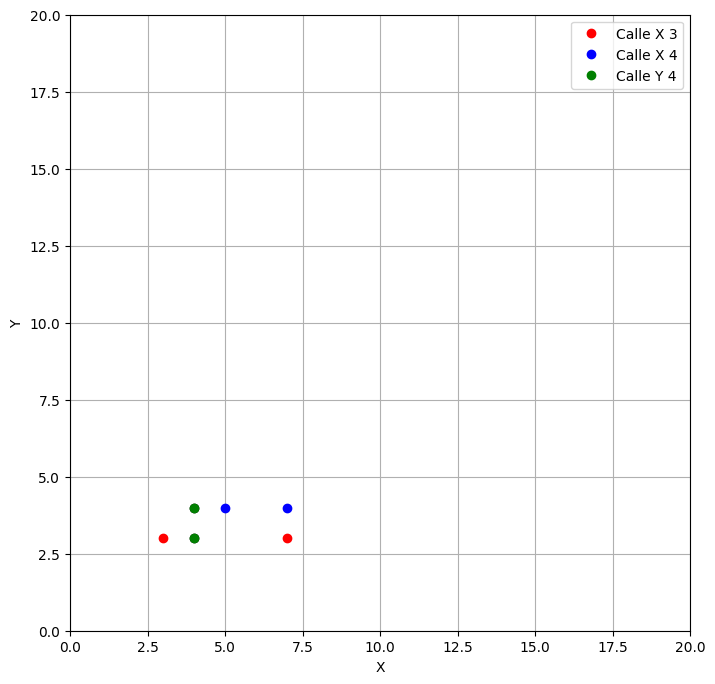

In [540]:
calles.update_secuencial(1)
print('-------------------')
print(str(calles.calles[0]))
print(str(calles.calles[1]))
#print(str(calles.calles[2]))
for interseccion in calles.intersecciones:
    print(str(interseccion))
print('-------------------')
calles.plot_2d()
